In [40]:
# Imports from the helpers folder, containing the lstm code and auxilliary functions
import sys  
sys.path.insert(0, "helpers/")
from lstm import Model, Optimization
from aux_functions import (dateindex_from_weeknum, dateindex_from_timestamp, ts_train_test_split, 
                           cols_with_most_corr, lagged_corr, lagged_corr_matrix, 
                           cols_with_most_lagged_corr, calculate_pvalues, corr_feature_selection)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.io as pltio
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency, kruskal
# Packages of forecasting models
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive, drift, mean, seasonal_naive)
import pmdarima as pm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data

In [69]:
# Daily sales data daily sales data
turin_data_df = pd.read_csv("../datasets/turin_daily.csv", index_col=[0], parse_dates=True)
print("Turin sales data:", turin_data_df.shape)
print(turin_data_df.head())
print("\n")

# Exogenous weather data
parser = lambda date: datetime.strptime(date, '%d/%m/%Y')
turin_weather_df = pd.read_csv("../datasets/Eso_data/weather/torino_weather_data.csv", index_col=[1], parse_dates=True, date_parser=parser)

Turin sales data: (1460, 1)
            qty
time           
2016-01-02  127
2016-01-03  105
2016-01-04   86
2016-01-05  213
2016-01-06  299




In [71]:
def augment_store_data (store_df, loc_weather_df):
    store_daily_totals = store_df

    # Check for NAN values in sales and replace them if they are present
    sales_nan_indices = store_daily_totals[store_daily_totals.isnull().any(axis=1)].index
    for nan_idx in sales_nan_indices:
        n_days_ago = nan_idx - timedelta(days=1)
        store_daily_totals.loc[nan_idx, "qty"] = np.mean(store_daily_totals.loc[n_days_ago:nan_idx,"qty"].values)
    
    ## WEATHER DATA
    
    # We won't be using the following cols (nan vals or categorical)
    loc_weather_df = loc_weather_df.drop(["LOCALITA", "PRESSIONEMEDIA mb", "PIOGGIA mm"], axis=1)
    loc_weather_df = loc_weather_df.loc[store_daily_totals.index[0]:,:]
    
    # Encode the weather phenomena
    # Nan (bello) = 2
    # Solo Pioggia = -1
    # Pioggia + extra = -2
    # Resto = 1
    loc_weather_df.FENOMENI.fillna(2, inplace=True)
    loc_weather_df.FENOMENI.replace(to_replace=loc_weather_df.FENOMENI[loc_weather_df.FENOMENI == "pioggia "], value=-1, inplace=True)
    pioggia_and_index = [True if (isinstance(fenomeno,str) and "pioggia" in fenomeno) else False for fenomeno in loc_weather_df.FENOMENI.values]
    loc_weather_df.FENOMENI.replace(to_replace=loc_weather_df.FENOMENI[pioggia_and_index], value=-2, inplace=True)
    the_others = [True if (isinstance(fenomeno,str)) else False for fenomeno in loc_weather_df.FENOMENI.values]
    loc_weather_df.FENOMENI.replace(to_replace=loc_weather_df.FENOMENI[the_others], value=1, inplace=True)

    # Now that the Fenomeni data is not NaN anymore, we also clear any actual NaN rows we might have
    # Check for NAN values in sales and replace them if they are present
    weather_nan_indices = loc_weather_df[loc_weather_df.isnull().any(axis=1)].index
    print(weather_nan_indices)
    for nan_idx in weather_nan_indices:
        for col in loc_weather_df.columns[:-1]:
            n_days_before = nan_idx - timedelta(days=1)
            loc_weather_df.loc[nan_idx, col] = np.mean(loc_weather_df.loc[n_days_before:nan_idx, col])
    
    # Here we add exogenous data we run the train the network with and without these new data. 
    # If the prediction improves then we are looking at leading indicator and better forecast accuracy.
    store_daily_weather_augmented = store_daily_totals.copy(deep=True)
    for w_col in loc_weather_df.columns:
        store_daily_weather_augmented[w_col] = loc_weather_df.loc[:, w_col]
   
    
    return store_daily_totals, store_daily_weather_augmented

# Augment single location sales data and then put everything together
turin_daily_default, turin_daily_augmented = augment_store_data(turin_data_df, turin_weather_df)
print("Turin data original shape:", turin_daily_default.shape)
print("Turin + exogenous data shape:", turin_daily_augmented.shape)
# Create copy of the augmented dataset to use for the models
turin_model_copy = turin_daily_augmented.iloc[:, :-1].copy(deep=True)

DatetimeIndex(['2016-04-04', '2017-01-26', '2019-02-05'], dtype='datetime64[ns]', name='DATA', freq=None)
Turin data original shape: (1460, 1)
Turin + exogenous data shape: (1460, 12)


# Scenario 1:  Sales and day of the week

This scenario explores how the day of the week is connected to the amount of sold produts. If we were to take a sample of the data we could actually see the sales quantity is mostly higher on Fridays (day 5) or the weekend. Of course this does not hold when we have seasonal sales, but that will be explored later.

In [4]:
#day_nr = np.array(list(map(int, turin_daily_augmented.index.strftime('%j').tolist())))
turin_daily_augmented["day_of_week"] = turin_daily_augmented.index.dayofweek
turin_daily_augmented.iloc[205:220, [0,-1]]

,qty,day_of_week
time,,
2016-07-25,89,0
2016-07-26,96,1
2016-07-27,122,2
2016-07-28,117,3
2016-07-29,111,4
2016-07-30,157,5
2016-07-31,152,6
2016-08-01,116,0
2016-08-02,80,1


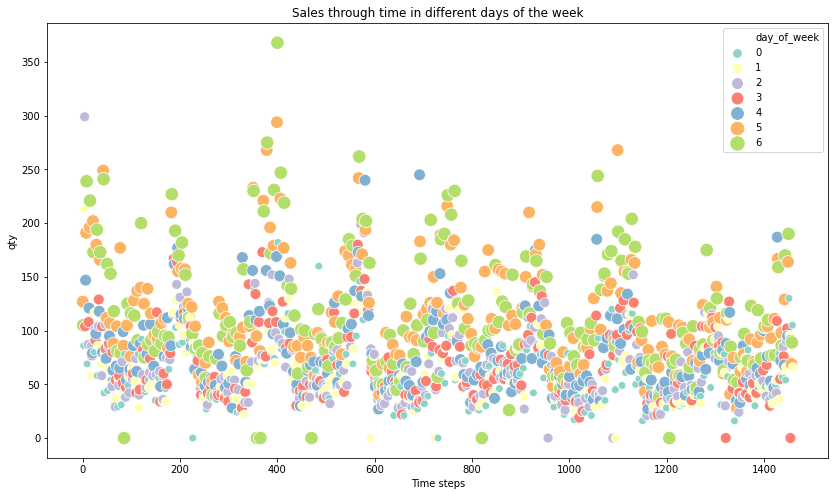

In [5]:
plt.figure(figsize=(14,8))
plt.title("Sales through time in different days of the week")
ax = sns.scatterplot(x=range(0, len(turin_daily_augmented)), y="qty", hue="day_of_week", palette="Set3",\
                     size="day_of_week", sizes=(60, 180), legend="full", data=turin_daily_augmented)
ax.set(xlabel="Time steps")
plt.show()

We can use a Kruskal-Wallis H-test, which tests the null hypothesis that the population medians of all of the groups are equal. It is a non-parametric version of ANOVA

In [6]:
kw_test = kruskal(turin_daily_augmented.qty, turin_daily_augmented.day_of_week)
print("Kruskal-Wallis H-test Test statistic:", kw_test[0])
print("Kruskal-Wallis H-test P-value:", kw_test[1])

Kruskal-Wallis H-test Test statistic: 2090.3096461675295
Kruskal-Wallis H-test P-value: 0.0


# Scenario 2: Sales and holidays (seasonal sales)

Most people go shopping and buy more things when there are longer periods of sales for certain holidays, like the Christmas and New Year period or also the two last summer months of July and August. This is something that can be seen by looking at the sales data we have and also an event that will probably keep happening every year.

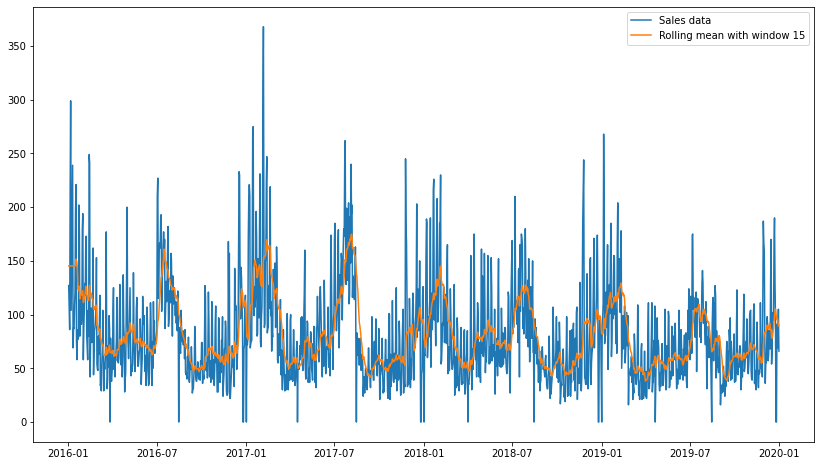

In [7]:
m=15
qty_roll_mean = turin_daily_augmented.qty.rolling(window=m).mean()
mean_first_m = np.mean(turin_daily_augmented.iloc[:15, 0])
full_roll_mean = qty_roll_mean.fillna(mean_first_m)

plt.figure(figsize=(14,8))
plt.plot(turin_daily_augmented.qty, label="Sales data")
plt.plot(full_roll_mean, label="Rolling mean with window "+str(m)) 
plt.legend()
plt.show()

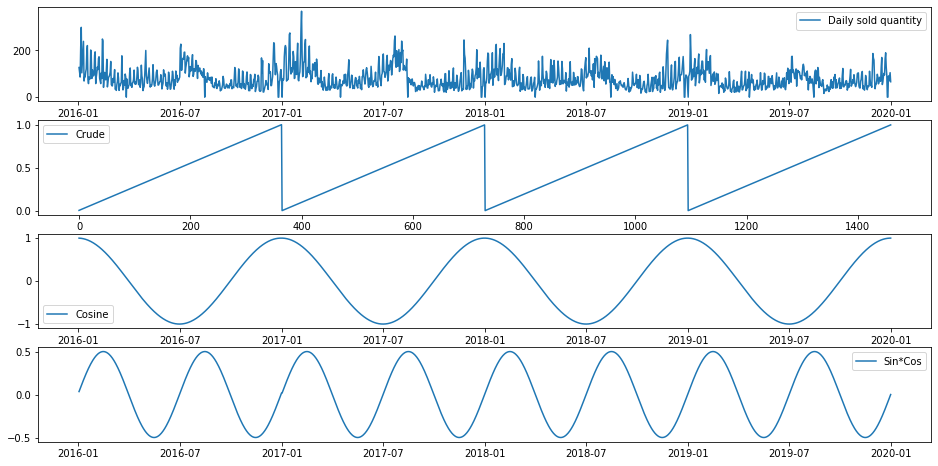

In [8]:
day_yearly_nr = np.array(list(map(int, turin_daily_augmented.index.strftime('%j').tolist())))
nrm_days = day_yearly_nr/365
turin_daily_augmented["sin_day"] =  np.sin((day_yearly_nr/365) * 2*np.pi)
turin_daily_augmented["cos_day"] = np.cos((day_yearly_nr/365) * 2*np.pi)
turin_daily_augmented["sincos_day"] = np.sin((day_yearly_nr/365) * 2*np.pi) * np.cos((day_yearly_nr/365) * 2*np.pi)

plt.figure(figsize=(16,8))
plt.subplot(4, 1, 1)
plt.plot(turin_daily_augmented.qty, label="Daily sold quantity")
plt.legend()
plt.subplot(4, 1, 2)
plt.plot(nrm_days, label="Crude")
plt.legend()
plt.subplot(4, 1, 3)
plt.plot(turin_daily_augmented.cos_day, label="Cosine")
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(turin_daily_augmented.sincos_day, label="Sin*Cos")
plt.legend()
plt.show()

In [9]:
print("Quantity - Cosined day Kruskal-Wallis H-test Test statistic:", kruskal(turin_daily_augmented.qty, turin_daily_augmented.sincos_day)[0])
print("Quantity - Cosined day Kruskal-Wallis H-test P-value:", kruskal(turin_daily_augmented.qty, turin_daily_augmented.sincos_day)[1])

Quantity - Cosined day Kruskal-Wallis H-test Test statistic: 2132.821773528021
Quantity - Cosined day Kruskal-Wallis H-test P-value: 0.0


In [10]:
random_seq = np.random.rand(len(turin_daily_augmented))
kruskal(turin_daily_augmented.qty, random_seq) # ???

KruskalResult(statistic=2076.796958422728, pvalue=0.0)

# Scenario 3: Sales and weather (exogenous variables)

In [11]:
new_signal_vals = [1 if val > full_roll_mean[idx] else -1 for idx, val in enumerate(turin_daily_augmented.qty.values)]
turin_daily_augmented["meanlbl"] = new_signal_vals
turin_daily_augmented["compatibility"] = turin_daily_augmented.FENOMENI * turin_daily_augmented.meanlbl
turin_daily_augmented

,qty,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,PRESSIONESLM mb,FENOMENI,day_of_week,sin_day,cos_day,sincos_day,meanlbl,compatibility
time,,,,,,,,,,,,,,,,,,
2016-01-02,127,3.0,2.0,4.0,2.0,92.0,2.0,4.0,11.0,0.0,1018.0,-1,5,3.442161e-02,0.999407,3.440121e-02,-1,1
2016-01-03,105,2.0,1.0,2.0,1.0,95.0,2.0,6.0,11.0,0.0,1009.0,1,6,5.161967e-02,0.998667,5.155085e-02,-1,-1
2016-01-04,86,1.0,0.0,2.0,1.0,93.0,3.0,5.0,9.0,0.0,1000.0,-2,0,6.880243e-02,0.997630,6.863939e-02,-1,2
2016-01-05,213,3.0,1.0,4.0,1.0,87.0,7.0,5.0,9.0,0.0,1000.0,2,1,8.596480e-02,0.996298,8.564657e-02,1,2
2016-01-06,299,3.0,-1.0,8.0,1.0,80.0,12.0,5.0,11.0,0.0,1001.0,2,2,1.031017e-01,0.994671,1.025522e-01,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,91,4.0,0.0,9.0,0.0,68.0,18.0,5.0,9.0,0.0,1022.0,2,4,-6.880243e-02,0.997630,-6.863939e-02,-1,-2
2019-12-28,69,3.0,-1.0,10.0,2.0,79.0,14.0,5.0,11.0,0.0,1030.0,2,5,-5.161967e-02,0.998667,-5.155085e-02,-1,-2
2019-12-29,89,3.0,0.0,8.0,2.0,84.0,7.0,5.0,9.0,0.0,1033.0,2,6,-3.442161e-02,0.999407,-3.440121e-02,-1,-2


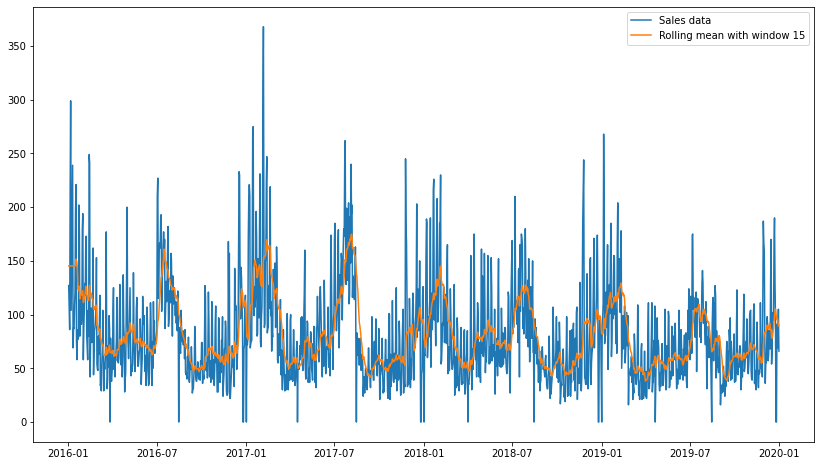

In [12]:
plt.figure(figsize=(14,8))
plt.plot(turin_daily_augmented.qty, label="Sales data")
plt.plot(full_roll_mean, label="Rolling mean with window "+str(m)) 
plt.legend()
plt.show()

In [13]:
# Chi-sq and contingency table for the weather phenomena and the mean amount of bought products
ctg_matrix = pd.crosstab(turin_daily_augmented["meanlbl"], turin_daily_augmented["FENOMENI"])
under_mean_total = np.sum(ctg_matrix.iloc[0, :])
over_mean_total = np.sum(ctg_matrix.iloc[1, :])
print(ctg_matrix)
print(ctg_matrix.iloc[0, :]/under_mean_total)
print(ctg_matrix.iloc[1, :]/over_mean_total)
# Good weather (no phenomena) makes you more likely to "not buy" (qty under the mean) than bad weather.
# Gotta check the mean condition here aka the rolling mean

FENOMENI   -2   -1   1    2
meanlbl                    
-1        136  147  57  514
 1        110  115  45  336
FENOMENI
-2    0.159251
-1    0.172131
 1    0.066745
 2    0.601874
Name: -1, dtype: float64
FENOMENI
-2    0.181518
-1    0.189769
 1    0.074257
 2    0.554455
Name: 1, dtype: float64


In [14]:
print((136+147)/(246+262),(57+514)/(102+850))

0.5570866141732284 0.5997899159663865


In [15]:
# Bin the data into an equal number of bins, based on their quartiles
exo_var = "TMAX °C"
qcut_res = pd.qcut(turin_daily_augmented[exo_var], q=4,retbins=True)
qcut_bins = qcut_res[1]
print("Temp bin vals:", qcut_bins, "\n")
binned_vals = []
for val in turin_daily_augmented[exo_var].values:
    if (val >= qcut_bins[0] and val <= qcut_bins[1]):
        binned_vals.append(1)
    elif (val > qcut_bins[1] and val <= qcut_bins[2]):
        binned_vals.append(2)
    elif (val > qcut_bins[2] and val <= qcut_bins[3]):
        binned_vals.append(3)
    else:
        binned_vals.append(4)

turin_daily_augmented["temp_binned"] = binned_vals
contig_matrix = pd.crosstab(turin_daily_augmented["meanlbl"], turin_daily_augmented["temp_binned"])
under_mean_total = np.sum(contig_matrix.iloc[0, :])
over_mean_total = np.sum(contig_matrix.iloc[1, :])
print(contig_matrix, "\n")
print(contig_matrix.iloc[0, :]/under_mean_total)
print(contig_matrix.iloc[1, :]/over_mean_total)

Temp bin vals: [-3.   11.75 19.   26.   37.  ] 

temp_binned    1    2    3    4
meanlbl                        
-1           201  258  197  198
 1           164  156  137  149 

temp_binned
1    0.235363
2    0.302108
3    0.230679
4    0.231850
Name: -1, dtype: float64
temp_binned
1    0.270627
2    0.257426
3    0.226073
4    0.245875
Name: 1, dtype: float64


In [16]:
#print((201+258)/(365+414),(197+198)/(334+347))
print((201+198)/(365+347),(258+197)/(414+334))

0.5603932584269663 0.6082887700534759


In [17]:
month_vals = []
for val in turin_daily_augmented.index.month.values:
    if (val == 1 or val == 2 or val == 12):
        month_vals.append(1)
    elif (val == 3 or val == 4 or val == 5):
        month_vals.append(2)
    elif (val == 6 or val == 7 or val== 8):
        month_vals.append(3)
    else:
        month_vals.append(4)
        
turin_daily_augmented["season"] = month_vals
turin_daily_augmented

,qty,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,PRESSIONESLM mb,FENOMENI,day_of_week,sin_day,cos_day,sincos_day,meanlbl,compatibility,temp_binned,season
time,,,,,,,,,,,,,,,,,,,,
2016-01-02,127,3.0,2.0,4.0,2.0,92.0,2.0,4.0,11.0,0.0,1018.0,-1,5,3.442161e-02,0.999407,3.440121e-02,-1,1,1,1
2016-01-03,105,2.0,1.0,2.0,1.0,95.0,2.0,6.0,11.0,0.0,1009.0,1,6,5.161967e-02,0.998667,5.155085e-02,-1,-1,1,1
2016-01-04,86,1.0,0.0,2.0,1.0,93.0,3.0,5.0,9.0,0.0,1000.0,-2,0,6.880243e-02,0.997630,6.863939e-02,-1,2,1,1
2016-01-05,213,3.0,1.0,4.0,1.0,87.0,7.0,5.0,9.0,0.0,1000.0,2,1,8.596480e-02,0.996298,8.564657e-02,1,2,1,1
2016-01-06,299,3.0,-1.0,8.0,1.0,80.0,12.0,5.0,11.0,0.0,1001.0,2,2,1.031017e-01,0.994671,1.025522e-01,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,91,4.0,0.0,9.0,0.0,68.0,18.0,5.0,9.0,0.0,1022.0,2,4,-6.880243e-02,0.997630,-6.863939e-02,-1,-2,1,1
2019-12-28,69,3.0,-1.0,10.0,2.0,79.0,14.0,5.0,11.0,0.0,1030.0,2,5,-5.161967e-02,0.998667,-5.155085e-02,-1,-2,1,1
2019-12-29,89,3.0,0.0,8.0,2.0,84.0,7.0,5.0,9.0,0.0,1033.0,2,6,-3.442161e-02,0.999407,-3.440121e-02,-1,-2,1,1


In [18]:
contig_matrix_qrt = pd.crosstab(turin_daily_augmented["meanlbl"], turin_daily_augmented["season"])
under_mean_total = np.sum(contig_matrix.iloc[0, :])
over_mean_total = np.sum(contig_matrix.iloc[1, :])
print(contig_matrix_qrt, "\n")
print(contig_matrix.iloc[0, :]/under_mean_total)
print(contig_matrix.iloc[1, :]/over_mean_total)

season     1    2    3    4
meanlbl                    
-1       210  222  213  209
 1       150  146  155  155 

temp_binned
1    0.235363
2    0.302108
3    0.230679
4    0.231850
Name: -1, dtype: float64
temp_binned
1    0.270627
2    0.257426
3    0.226073
4    0.245875
Name: 1, dtype: float64


In [67]:
turin_daily_augmented["roll_mean"] = full_roll_mean
turin_daily_augmented

,qty,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,...,FENOMENI,day_of_week,sin_day,cos_day,sincos_day,meanlbl,compatibility,temp_binned,season,roll_mean
time,,,,,,,,,,,,,,,,,,,,,
2016-01-02,127,3.0,2.0,4.0,2.0,92.0,2.0,4.0,11.0,0.0,...,-1,5,3.442161e-02,0.999407,3.440121e-02,-1,1,1,1,145.333333
2016-01-03,105,2.0,1.0,2.0,1.0,95.0,2.0,6.0,11.0,0.0,...,1,6,5.161967e-02,0.998667,5.155085e-02,-1,-1,1,1,145.333333
2016-01-04,86,1.0,0.0,2.0,1.0,93.0,3.0,5.0,9.0,0.0,...,-2,0,6.880243e-02,0.997630,6.863939e-02,-1,2,1,1,145.333333
2016-01-05,213,3.0,1.0,4.0,1.0,87.0,7.0,5.0,9.0,0.0,...,2,1,8.596480e-02,0.996298,8.564657e-02,1,2,1,1,145.333333
2016-01-06,299,3.0,-1.0,8.0,1.0,80.0,12.0,5.0,11.0,0.0,...,2,2,1.031017e-01,0.994671,1.025522e-01,1,2,1,1,145.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,91,4.0,0.0,9.0,0.0,68.0,18.0,5.0,9.0,0.0,...,2,4,-6.880243e-02,0.997630,-6.863939e-02,-1,-2,1,1,96.333333
2019-12-28,69,3.0,-1.0,10.0,2.0,79.0,14.0,5.0,11.0,0.0,...,2,5,-5.161967e-02,0.998667,-5.155085e-02,-1,-2,1,1,96.400000
2019-12-29,89,3.0,0.0,8.0,2.0,84.0,7.0,5.0,9.0,0.0,...,2,6,-3.442161e-02,0.999407,-3.440121e-02,-1,-2,1,1,93.733333


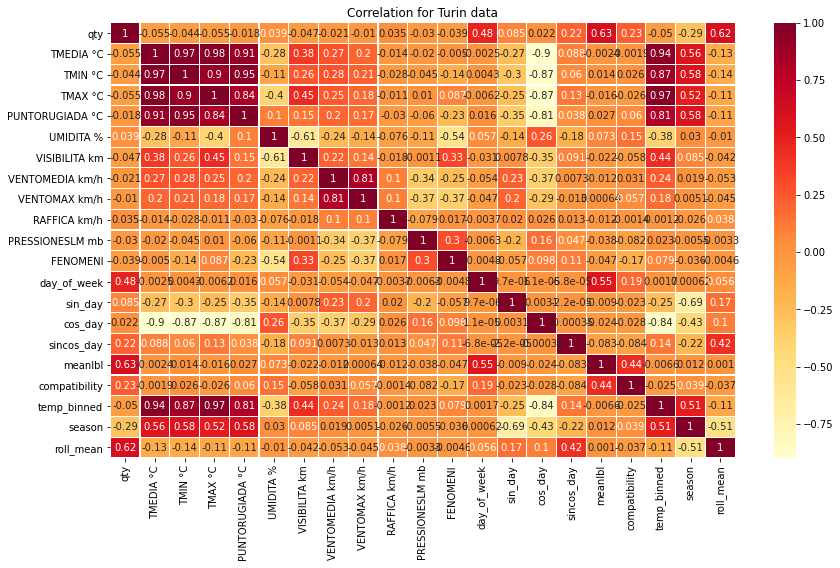

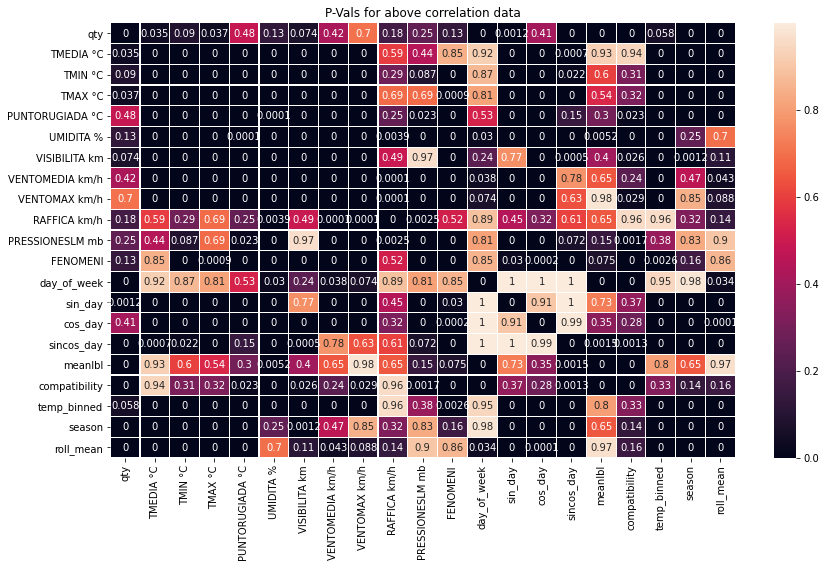

In [68]:
# Correlation in the data with added exogenous variables: Spearman Correlation
default_s_corr = turin_daily_augmented.corr(method="spearman")
plt.figure(figsize=(14,8))
sns.heatmap(data=default_s_corr, cmap="YlOrRd", annot=True, linewidths=.1)
plt.title("Correlation for Turin data")
plt.show()

def_p_val_matrix = calculate_pvalues(turin_daily_augmented, lag=0)
plt.figure(figsize=(14,8))
sns.heatmap(data=def_p_val_matrix, annot=True, linewidths=.1)
plt.title("P-Vals for above correlation data")
plt.show()

In [20]:
from sklearn.metrics import adjusted_mutual_info_score

mis_matrix = np.zeros(shape=(len(turin_daily_augmented.columns), len(turin_daily_augmented.columns)))
for i in range(0,mis_matrix.shape[0]):
    for j in range(0, mis_matrix.shape[1]):
        mis_matrix[i][j] = adjusted_mutual_info_score(turin_daily_augmented.iloc[:,i].values, turin_daily_augmented.iloc[:,j].values)

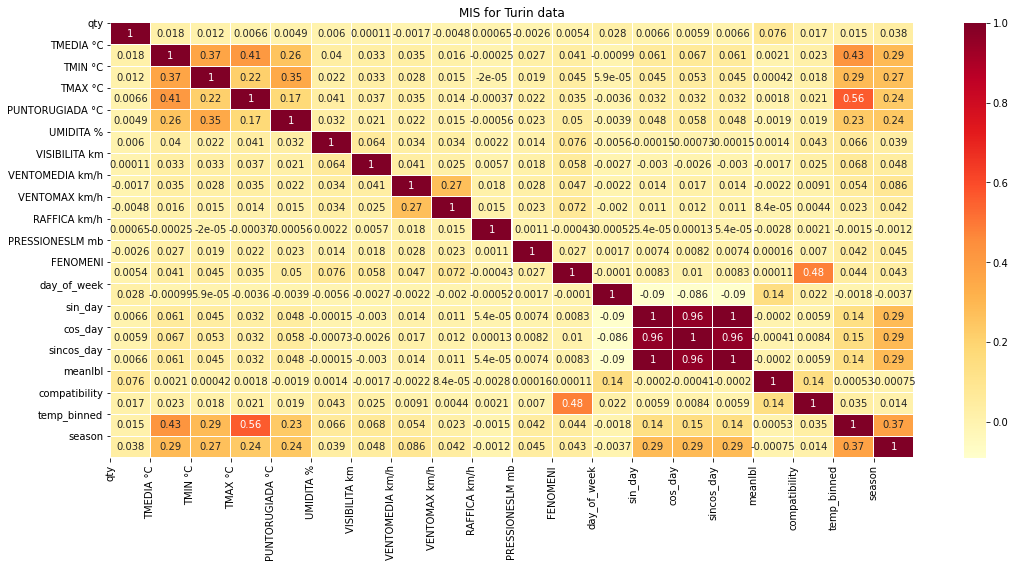

In [21]:
plt.figure(figsize=(18,8))        
sns.heatmap(data=mis_matrix, cmap="YlOrRd", annot=True, linewidths=.1)
plt.xticks(ticks=np.arange(mis_matrix.shape[0]), labels=turin_daily_augmented.columns.values, rotation=90)
plt.yticks(np.arange(mis_matrix.shape[1]), labels=turin_daily_augmented.columns.values, rotation=360)
plt.title("MIS for Turin data")
plt.show()

# LSTM helper functions

In [22]:
def build_in_out_seq(tr_df, te_df, desired_input_features, in_len, out_len):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.
    
    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(out_len, out_len+in_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(out_len)], axis=1)[out_len+in_len-1:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")

    return inp_tr, out_tr, inp_te, out_te

In [23]:
def prepare_for_network(train, test, input_features, in_len, out_len):
    # Build the full training and testing dataframes
    # In order to pass the data to the LSTM we need to transform it so it is in the range [0,1]
    # We scale all our data in order to build the final training and test dataframes
    
    
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    
    for col in tr_df.columns:
        # Z standartization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std

    # Prepare data for the LSTM Network: We need to create sequences of inputs and outputs
    # so that our time series problem esentially becomes a "supervised regression problem".
    inp_tr, out_tr, inp_te, out_te = build_in_out_seq(tr_df, pd.concat([tr_df.iloc[-in_len:, :], te_df]), input_features, in_len, out_len)
    return inp_tr, out_tr, inp_te, out_te

In [54]:
def define_LSTM_Model(input_features):
    loss_fn = nn.MSELoss()
    LSTM_Model = Model(input_size=len(input_features), hidden_size=len(input_features)*5, output_size=len(input_features))
    optimizer = optim.Adam(LSTM_Model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)
    opt_obj = Optimization(LSTM_Model, loss_fn, optimizer, scheduler)
    return LSTM_Model, opt_obj

In [32]:
def check_lstm_forecast_results(pred, inp_te, out_te, poll_mean, poll_std, in_len, out_len):
    # Rescales the data back to nrm vals first
    pred_vec = (pred[0,-out_len:,0].detach().cpu().numpy() * poll_std) + poll_mean
    real_vec = (out_te[0,:,0] * poll_std) + poll_mean
    rmse = sm.tools.eval_measures.rmse(pred_vec, real_vec)
    mae = sm.tools.eval_measures.meanabs(pred_vec, real_vec)
    return rmse, mae

# Forecasting evaluation

In [65]:
single_run_results = []
n_runs = 1

for run in range(n_runs):
    print ("Run #", run+1)
    # Load the default and augmented versions of the data
    # sin cos of day of year signal
    day_nr = np.array(list(map(int, turin_model_copy.index.strftime('%j').tolist())))
    turin_model_copy["sin_day"] =  np.sin((day_nr/365) * 2*np.pi)
    turin_model_copy["cos_day"] = np.cos((day_nr/365) * 2*np.pi)
    turin_model_copy["sincos_day"] = np.sin((day_nr/365) * 2*np.pi) * np.cos((day_nr/365) * 2*np.pi)
    aug_dataset = turin_model_copy
    
    # Create training and test data
    train, test = ts_train_test_split(aug_dataset, test_length=0.1)
    print(train.shape, test.shape)

    # Extract the columns which display most correlation with the value we are trying to predict.
    mono_input_features = [0]
    exo1_input_features = [0, 11, 12, 13]
    exo2_input_features = list(range(0,aug_dataset.shape[1]-3))
    exo3_input_features = list(range(0,aug_dataset.shape[1]))
    print("MONO-LSTM input features:", mono_input_features)
    print("EXO1 (+ sincos day) input features :", exo1_input_features)
    print("EXO2 (+ weather exog) input features :", exo2_input_features)
    print("EXO3 (+ all exog) input features :", exo3_input_features)
    print()
    
    # Define steps ahead to forecast
    f_steps = test.shape[0]

    ## Run STL Decomposition as baseline
    print("Running Drift model based on STL Decomposition...")
    decomp = decompose(train.qty, period=7)
    drift_forecast = forecast(decomp, steps=f_steps, fc_func=drift, seasonal=True)
    drift_rmse = sm.tools.eval_measures.rmse(test.qty.values, drift_forecast["drift+seasonal"].values)
    drift_mae = sm.tools.eval_measures.meanabs(test.qty.values, drift_forecast["drift+seasonal"].values)
    print("Done\n")
    
    ## Run ARIMA as another baseline
    print("Running ARIMA model...")
    # Fit your model
    arima_model = pm.auto_arima(train.qty, suppress_warnings=True, max_order=None, \
                                seasonal=True, start_p=3, start_q=0, start_P=0, start_Q=0, \
                                max_p=6, max_d=1, max_q=1, max_P=1, max_D=1, max_Q=1)
    arima_order = arima_model.get_params()["order"]
    arima_fitted = arima_model.fit(train.qty)
    arima_forecasts = arima_fitted.predict(f_steps)  
    arima_rmse = sm.tools.eval_measures.rmse(test.qty.values, arima_forecasts)
    arima_mae = sm.tools.eval_measures.meanabs(test.qty.values, arima_forecasts)
    print("Done\n")
    
    # Run ARIMAX as another baseline
    print("Running ARIMAX model...")
    arimax_fitted = arima_model.fit(y=train.qty, exogenous=train.iloc[:, 1:])
    arimax_forecasts = arimax_fitted.predict(f_steps, exogenous=test.iloc[:, 1:])  
    arimax_rmse = sm.tools.eval_measures.rmse(test.qty.values, arimax_forecasts)
    arimax_mae = sm.tools.eval_measures.meanabs(test.qty.values, arimax_forecasts)
    print("Done\n")
   

    ## LSTM
    # Define the LSTM Models and their Optimizer objects
    mono_LSTM_Model, mono_opt_obj = define_LSTM_Model(mono_input_features)
    exo1_LSTM_Model, exo1_opt_obj = define_LSTM_Model(exo1_input_features)
    exo2_LSTM_Model, exo2_opt_obj = define_LSTM_Model(exo2_input_features)
    exo3_LSTM_Model, exo3_opt_obj = define_LSTM_Model(exo3_input_features)
    
    # 1) MONO-LSTM data
    mono_inp_tr, mono_out_tr, mono_inp_te, mono_out_te = prepare_for_network(train, test, mono_input_features, in_len=390, out_len=f_steps)
    mono_x_train=torch.cat((torch.Tensor(mono_inp_tr),torch.Tensor(mono_out_tr)),1)
    mono_x_test=torch.Tensor(mono_inp_te)
    
    # 2) EXO1-LSTM data
    exo1_inp_tr, exo1_out_tr, exo1_inp_te, exo1_out_te = prepare_for_network(train, test, exo1_input_features, in_len=390, out_len=f_steps)
    exo1_x_train=torch.cat((torch.Tensor(exo1_inp_tr),torch.Tensor(exo1_out_tr)),1)
    exo1_x_test=torch.Tensor(exo1_inp_te)
    
    # 3) EXO2-LSTM data
    exo2_inp_tr, exo2_out_tr, exo2_inp_te, exo2_out_te = prepare_for_network(train, test, exo2_input_features, in_len=390, out_len=f_steps)
    exo2_x_train=torch.cat((torch.Tensor(exo2_inp_tr),torch.Tensor(exo2_out_tr)),1)
    exo2_x_test=torch.Tensor(exo2_inp_te)
    
    # 4) EXO3-LSTM data
    exo3_inp_tr, exo3_out_tr, exo3_inp_te, exo3_out_te = prepare_for_network(train, test, exo3_input_features, in_len=390, out_len=f_steps)
    exo3_x_train=torch.cat((torch.Tensor(exo3_inp_tr),torch.Tensor(exo3_out_tr)),1)
    exo3_x_test=torch.Tensor(exo3_inp_te)

    # Train all the LSTMs 
    print("Training the MONO-LSTM model...")
    mono_opt_obj.train(mono_x_train[:,:-1],mono_x_train[:,1:],mono_x_train[:,:-1],mono_x_train[:,1:], \
                       do_teacher_forcing=True, n_epochs=10+len(mono_input_features)*3, batch_size=128)
    print("Done\n")
    print("Training the EXO1-LSTM model...")
    exo1_opt_obj.train(exo1_x_train[:,:-1],exo1_x_train[:,1:],exo1_x_train[:,:-1],exo1_x_train[:,1:], \
                       do_teacher_forcing=True, n_epochs=10+len(exo1_input_features)*3, batch_size=128)
    print("Done\n")
    print("Training the EXO2-LSTM model...")
    exo2_opt_obj.train(exo2_x_train[:,:-1],exo2_x_train[:,1:],exo2_x_train[:,:-1],exo2_x_train[:,1:], \
                       do_teacher_forcing=True, n_epochs=10+len(exo2_input_features)*3, batch_size=128)
    print("Done\n")
    print("Training the EXO3-LSTM model...")
    exo3_opt_obj.train(exo3_x_train[:,:-1],exo3_x_train[:,1:],exo3_x_train[:,:-1],exo3_x_train[:,1:], \
                       do_teacher_forcing=True, n_epochs=10+len(exo3_input_features)*3, batch_size=128)
    print("Done\n")

    # Make predictions using the trained networks
    mono_pred = mono_LSTM_Model(mono_x_test, f_steps)
    exo1_pred = exo1_LSTM_Model(exo1_x_test, f_steps)
    exo2_pred = exo2_LSTM_Model(exo2_x_test, f_steps)
    exo3_pred = exo3_LSTM_Model(exo3_x_test, f_steps)

    ## Check results of LSTM forecasts (calc erros)
    mean = np.mean(train.qty.values)
    std = np.std(train.qty.values)
    mono_lstm_rmse, mono_lstm_mae = check_lstm_forecast_results(mono_pred, mono_inp_te, mono_out_te, mean, std, in_len=390, out_len=f_steps)
    exo1_lstm_rmse, exo1_lstm_mae = check_lstm_forecast_results(exo1_pred, exo1_inp_te, exo1_out_te, mean, std, in_len=390, out_len=f_steps)
    exo2_lstm_rmse, exo2_lstm_mae = check_lstm_forecast_results(exo2_pred, exo2_inp_te, exo2_out_te, mean, std, in_len=390, out_len=f_steps)
    exo3_lstm_rmse, exo3_lstm_mae = check_lstm_forecast_results(exo3_pred, exo3_inp_te, exo3_out_te, mean, std, in_len=390, out_len=f_steps)

    fig = go.Figure()
    x_labels = list(range(0,f_steps))
    fig.add_trace(go.Scatter(x=x_labels, y=test.qty,
                mode='lines', name='GT'))
    fig.add_trace(go.Scatter(x=x_labels, y=drift_forecast["drift+seasonal"].values,
                mode='lines', name='DRIFT'))
    fig.add_trace(go.Scatter(x=x_labels, y=arima_forecasts,
                mode='lines', name='ARIMA'+str(arima_order)))
    fig.add_trace(go.Scatter(x=x_labels, y=arimax_forecasts,
                mode='lines', name='ARIMAX'+str(arima_order)))
    fig.add_trace(go.Scatter(x=x_labels, y=(mono_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                 mode='lines', name='MONO-LSTM'))
    fig.add_trace(go.Scatter(x=x_labels, y=(exo1_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                 mode='lines', name='EXO1-LSTM'))
    fig.add_trace(go.Scatter(x=x_labels, y=(exo2_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                 mode='lines', name='EXO2-LSTM'))
    fig.add_trace(go.Scatter(x=x_labels, y=(exo3_pred[0,-f_steps:,0].detach().cpu().numpy()*std)+mean,
                 mode='lines', name='EXO3-LSTM'))
    #Update plot title and axis titles, then save plot as a HTML File
    fig.update_layout(
        title="Forecast of test set",
        xaxis_title="Time steps",
        yaxis_title="Prediction",
        font=dict(
            family="Courier New, monospace",
            size=16,
            color="#7f7f7f"
        )
    )
    fig.show()
    #pltio.write_html(fig, dataset+"-"+"run"+str(run+1)+"daily-sales-results.html")
    single_run_results.append(["Torino", "run "+str(run+1), drift_rmse, arima_rmse, arimax_rmse, \
                               mono_lstm_rmse, exo1_lstm_rmse, exo2_lstm_rmse, exo3_lstm_rmse, \
                               drift_mae, arima_mae, arimax_mae, mono_lstm_mae, exo1_lstm_mae, \
                               exo2_lstm_mae, exo3_lstm_mae])
    
    print()


Run # 1
(1314, 14) (146, 14)
MONO-LSTM input features: [0]
EXO1 (+ sincos day) input features : [0, 11, 12, 13]
EXO2 (+ weather exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
EXO3 (+ all exog) input features : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

Running Drift model based on STL Decomposition...
Done

Running ARIMA model...
Done

Running ARIMAX model...
Done

Inputs for training
(789, 380, 1)
Outputs for training
(789, 146, 1)
Inputs for testing
(1, 380, 1)
Outputs for testing
(1, 146, 1)


Inputs for training
(789, 380, 4)
Outputs for training
(789, 146, 4)
Inputs for testing
(1, 380, 4)
Outputs for testing
(1, 146, 4)


Inputs for training
(789, 380, 11)
Outputs for training
(789, 146, 11)
Inputs for testing
(1, 380, 11)
Outputs for testing
(1, 146, 11)


Inputs for training
(789, 380, 14)
Outputs for training
(789, 146, 14)
Inputs for testing
(1, 380, 14)
Outputs for testing
(1, 146, 14)


Training the MONO-LSTM model...
Epoch 1 Train loss: 1.45. Validation los

Epoch 2 Train loss: 1.04. Validation loss: 0.97. Avg future: 175.33. Elapsed time: 13.38s.
Epoch 3 Train loss: 0.94. Validation loss: 0.86. Avg future: 119.50. Elapsed time: 15.54s.
Epoch 4 Train loss: 0.83. Validation loss: 0.72. Avg future: 142.50. Elapsed time: 9.78s.
Epoch 5 Train loss: 0.70. Validation loss: 0.64. Avg future: 148.17. Elapsed time: 10.11s.
Epoch 6 Train loss: 0.63. Validation loss: 0.58. Avg future: 134.00. Elapsed time: 13.54s.
Epoch 7 Train loss: 0.56. Validation loss: 0.54. Avg future: 96.67. Elapsed time: 11.87s.
Epoch 8 Train loss: 0.53. Validation loss: 0.51. Avg future: 107.83. Elapsed time: 9.25s.
Epoch 9 Train loss: 0.51. Validation loss: 0.49. Avg future: 118.17. Elapsed time: 12.67s.
Epoch 10 Train loss: 0.49. Validation loss: 0.48. Avg future: 182.00. Elapsed time: 19.11s.
Epoch 11 Train loss: 0.47. Validation loss: 0.47. Avg future: 139.83. Elapsed time: 18.05s.
Epoch 12 Train loss: 0.46. Validation loss: 0.46. Avg future: 134.83. Elapsed time: 12.54s.

In [66]:
# Results for each run of forecasting
single_run_results_df = pd.DataFrame(single_run_results, 
                                     columns=["Dataset", "Run Nr.", "DRIFT RMSE", "ARIMA RMSE", "ARIMAX RMSE",\
                                              "MONO-LSTM RMSE", "EXO1-LSTM RMSE", "EXO2-LSTM RMSE", "EXO3-LSTM RMSE",\
                                              "DRIFT MAE", "ARIMA MAE", "ARIMAX MAE", "MONO-LSTM MAE",\
                                              "EXO1-LSTM MAE", "EXO2-LSTM MAE", "EXO3-LSTM MAE"])

#single_run_results_df = pd.DataFrame(single_run_results, 
#                                     columns=["Dataset", "Run Nr.", "DRIFT RMSE", "MONO-LSTM RMSE", "EXO1-LSTM RMSE", \
#                                              "EXO2-LSTM RMSE", "EXO3-LSTM RMSE",\
#                                              "DRIFT MAE", "MONO-LSTM MAE",\
#                                              "EXO1-LSTM MAE", "EXO2-LSTM MAE", "EXO3-LSTM MAE"])
#
single_run_results_df

,Dataset,Run Nr.,DRIFT RMSE,ARIMA RMSE,ARIMAX RMSE,MONO-LSTM RMSE,EXO1-LSTM RMSE,EXO2-LSTM RMSE,EXO3-LSTM RMSE,DRIFT MAE,ARIMA MAE,ARIMAX MAE,MONO-LSTM MAE,EXO1-LSTM MAE,EXO2-LSTM MAE,EXO3-LSTM MAE
0,Torino,run 1,34.561244,35.196789,35.903039,45.513765,35.681834,34.739042,35.500552,26.292022,26.515244,25.837161,39.301321,26.69603,25.59767,25.289241


In [62]:
# Aggregate results
mean_results = single_run_results_df.copy(deep=True)
mean_results = mean_results.groupby(["Dataset"]).agg(np.mean)
mean_results

,DRIFT RMSE,ARIMA RMSE,ARIMAX RMSE,MONO-LSTM RMSE,EXO1-LSTM RMSE,EXO2-LSTM RMSE,EXO3-LSTM RMSE,DRIFT MAE,ARIMA MAE,ARIMAX MAE,MONO-LSTM MAE,EXO1-LSTM MAE,EXO2-LSTM MAE,EXO3-LSTM MAE
Dataset,,,,,,,,,,,,,,
Torino,34.561244,35.196789,35.903039,37.164696,32.725672,34.752527,36.123993,26.292022,26.515244,25.837161,30.615855,24.188285,27.741345,24.994417


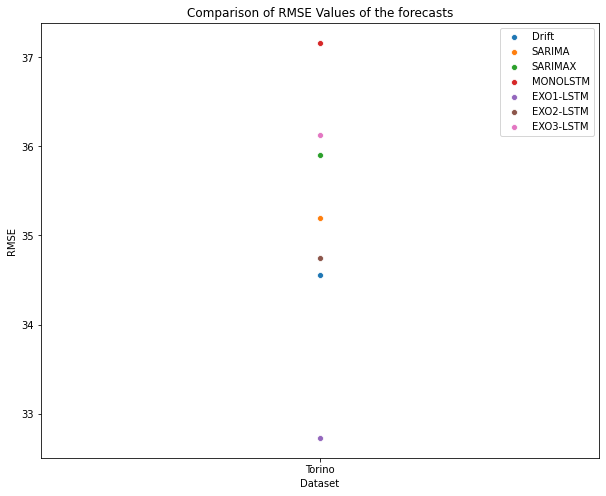

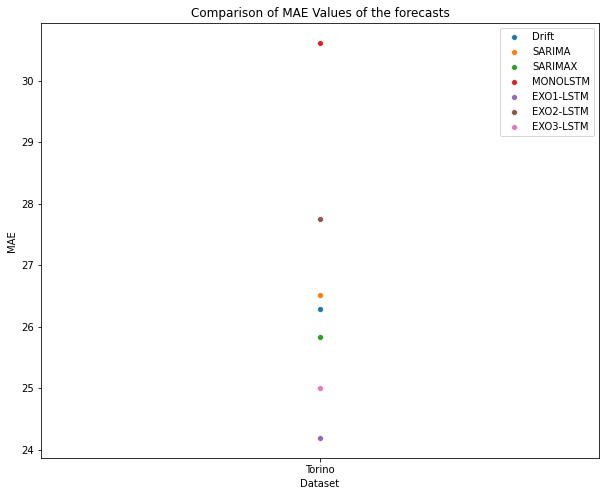

In [64]:
# Graphic comparison of error values: RMSE
plt.figure(figsize=(10,8))
plt.title("Comparison of RMSE Values of the forecasts")
ax = sns.scatterplot(x=mean_results.index, y="DRIFT RMSE", data=mean_results, label="Drift")
ax = sns.scatterplot(x=mean_results.index, y="ARIMA RMSE", data=mean_results, label="SARIMA")
ax = sns.scatterplot(x=mean_results.index, y="ARIMAX RMSE", data=mean_results, label="SARIMAX")
ax = sns.scatterplot(x=mean_results.index, y="MONO-LSTM RMSE", data=mean_results, label="MONOLSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO1-LSTM RMSE", data=mean_results, label="EXO1-LSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO2-LSTM RMSE", data=mean_results, label="EXO2-LSTM")
ax = sns.scatterplot(x=mean_results.index, y="EXO3-LSTM RMSE", data=mean_results, label="EXO3-LSTM")
ax.set(ylabel="RMSE")
plt.show()

# Graphic comparison of error values: MAE
plt.figure(figsize=(10,8))
plt.title("Comparison of MAE Values of the forecasts")
aax = sns.scatterplot(x=mean_results.index, y="DRIFT MAE", data=mean_results, label="Drift")
aax = sns.scatterplot(x=mean_results.index, y="ARIMA MAE", data=mean_results, label="SARIMA")
aax = sns.scatterplot(x=mean_results.index, y="ARIMAX MAE", data=mean_results, label="SARIMAX")
aax = sns.scatterplot(x=mean_results.index, y="MONO-LSTM MAE", data=mean_results, label="MONOLSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO1-LSTM MAE", data=mean_results, label="EXO1-LSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO2-LSTM MAE", data=mean_results, label="EXO2-LSTM")
aax = sns.scatterplot(x=mean_results.index, y="EXO3-LSTM MAE", data=mean_results, label="EXO3-LSTM")
aax.set(ylabel="MAE")
plt.show()